In [3]:
import sys
sys.path.append('../')

,image_name,label,path,train,label_id,image_id
0,image25107.jpg,apparel,images/apparel/image25107.jpg,True,9,0
1,image26799.jpg,apparel,images/apparel/image26799.jpg,True,9,1
2,image23088.jpg,apparel,images/apparel/image23088.jpg,True,9,2
3,image0421.jpg,apparel,images/apparel/image0421.jpg,True,9,3


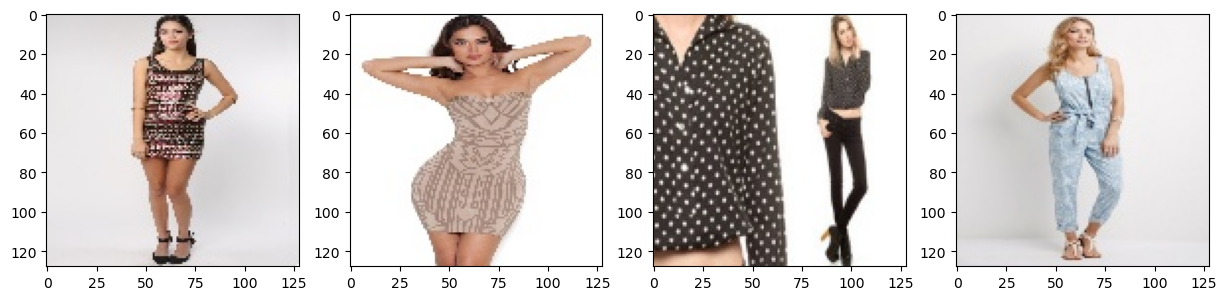

In [4]:
import cv2                      # Image Ops
import pandas as pd             # Other
import numpy as np              # Mat Opts
import matplotlib.pyplot as plt # Show Images

from utils.utils import load_images
from utils.features import load_features, save_features, extract_features
from utils.matching import minmin_retrival, match_all_images
from utils.scoring import calculate_metrics

from functools import partial

image_meta, images = load_images(True) # True - Train Images
display(image_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(images[0]);
ax[1].imshow(images[1]);
ax[2].imshow(images[2]);
ax[3].imshow(images[3]);

# Características
Se plantea usar como características el histograma de diferencia de color para imágenes RGB. Se explica en la [siguiente publicación](https://www.sciencedirect.com/science/article/pii/S0031320312002713?via%3Dihub)
 

In [5]:
b = 32
def normalize(vector):
    return vector / np.linalg.norm(vector)

def cch_descriptor(image, bins = 32):
    rbin = normalize(np.histogram(image[:, :, 0], bins = bins, range = [0, 255])[1])
    gbin = normalize(np.histogram(image[:, :, 1], bins = bins, range = [0, 255])[1])
    bbin = normalize(np.histogram(image[:, :, 2], bins = bins, range = [0, 255])[1])

    return np.concatenate([rbin, gbin, bbin], axis = 0).reshape(1, -1).astype(np.float32) # Un Vector con solo columnas

cch_descriptor_func = partial(cch_descriptor, bins = b)

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
descriptors, index = extract_features(cch_descriptor_func, images, min_features=1, progress = True)
print("Tamaño de  descriptores:", descriptors.shape[1])
print("Número de  descriptores:", descriptors.shape[0])
print("Número Máximo de Descriptores Por Imágen :", pd.value_counts(index).max())
print("Número Medio  de Descriptores Por Imágen :", pd.value_counts(index).mean().round(0).astype(int))
print("Número Mínimo de Descriptores Por Imágen :", pd.value_counts(index).min())

# Obligatorio Siempre Guardar
save_features(descriptors, index, image_meta, "CCH")

  0%|          | 0/550 [00:00<?, ?it/s]

Tamaño de  descriptores: 99
Número de  descriptores: 550
Número Máximo de Descriptores Por Imágen : 1
Número Medio  de Descriptores Por Imágen : 1
Número Mínimo de Descriptores Por Imágen : 1


In [8]:
desc_meta, descriptors = load_features("../features/CCH.csv") # Siempre Cargar
display(desc_meta.head())
display(descriptors.dtype)

,image_id,label_id
0,0,9
1,1,9
2,2,9
3,3,9
4,4,9


dtype('float32')

,image_name,label,path,train,label_id,image_id
0,image6479.jpg,apparel,images/apparel/image6479.jpg,False,9,0
1,image2791.jpg,apparel,images/apparel/image2791.jpg,False,9,1
2,image9608.jpg,apparel,images/apparel/image9608.jpg,False,9,2
3,image26288.jpg,apparel,images/apparel/image26288.jpg,False,9,3


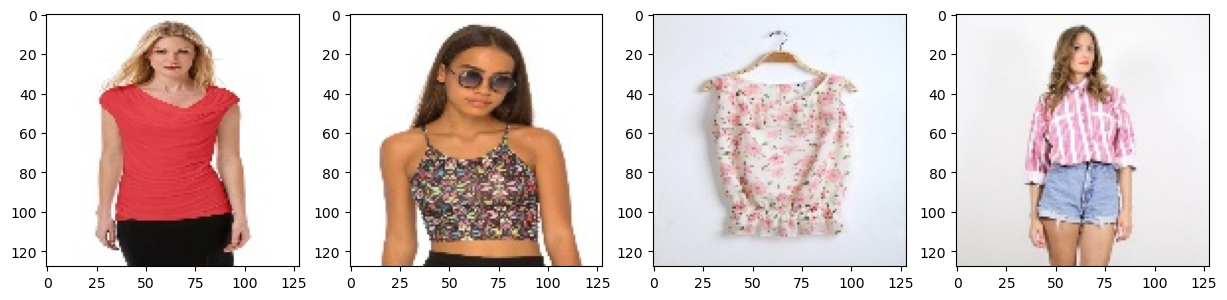

In [9]:
test_meta, test_images = load_images(False)

display(test_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(test_images[0]);
ax[1].imshow(test_images[1]);
ax[2].imshow(test_images[2]);
ax[3].imshow(test_images[3]);


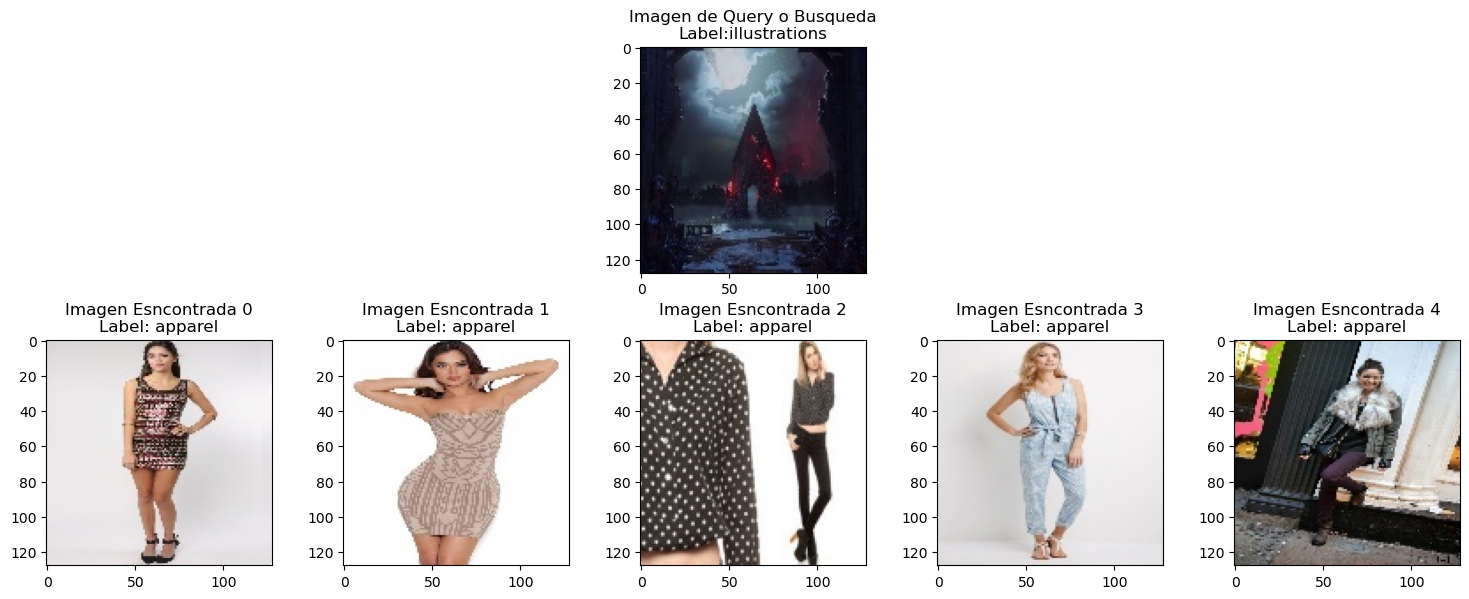

In [10]:
img = test_images[50]
descs = partial(cch_descriptor, bins = b)(img)
ret_idx = minmin_retrival(descs, descriptors, desc_meta, best_k=5, distance_function=cv2.NORM_L2)

fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

test_img = 50
ax[0][2].imshow(img)
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(ret_idx[:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Esncontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


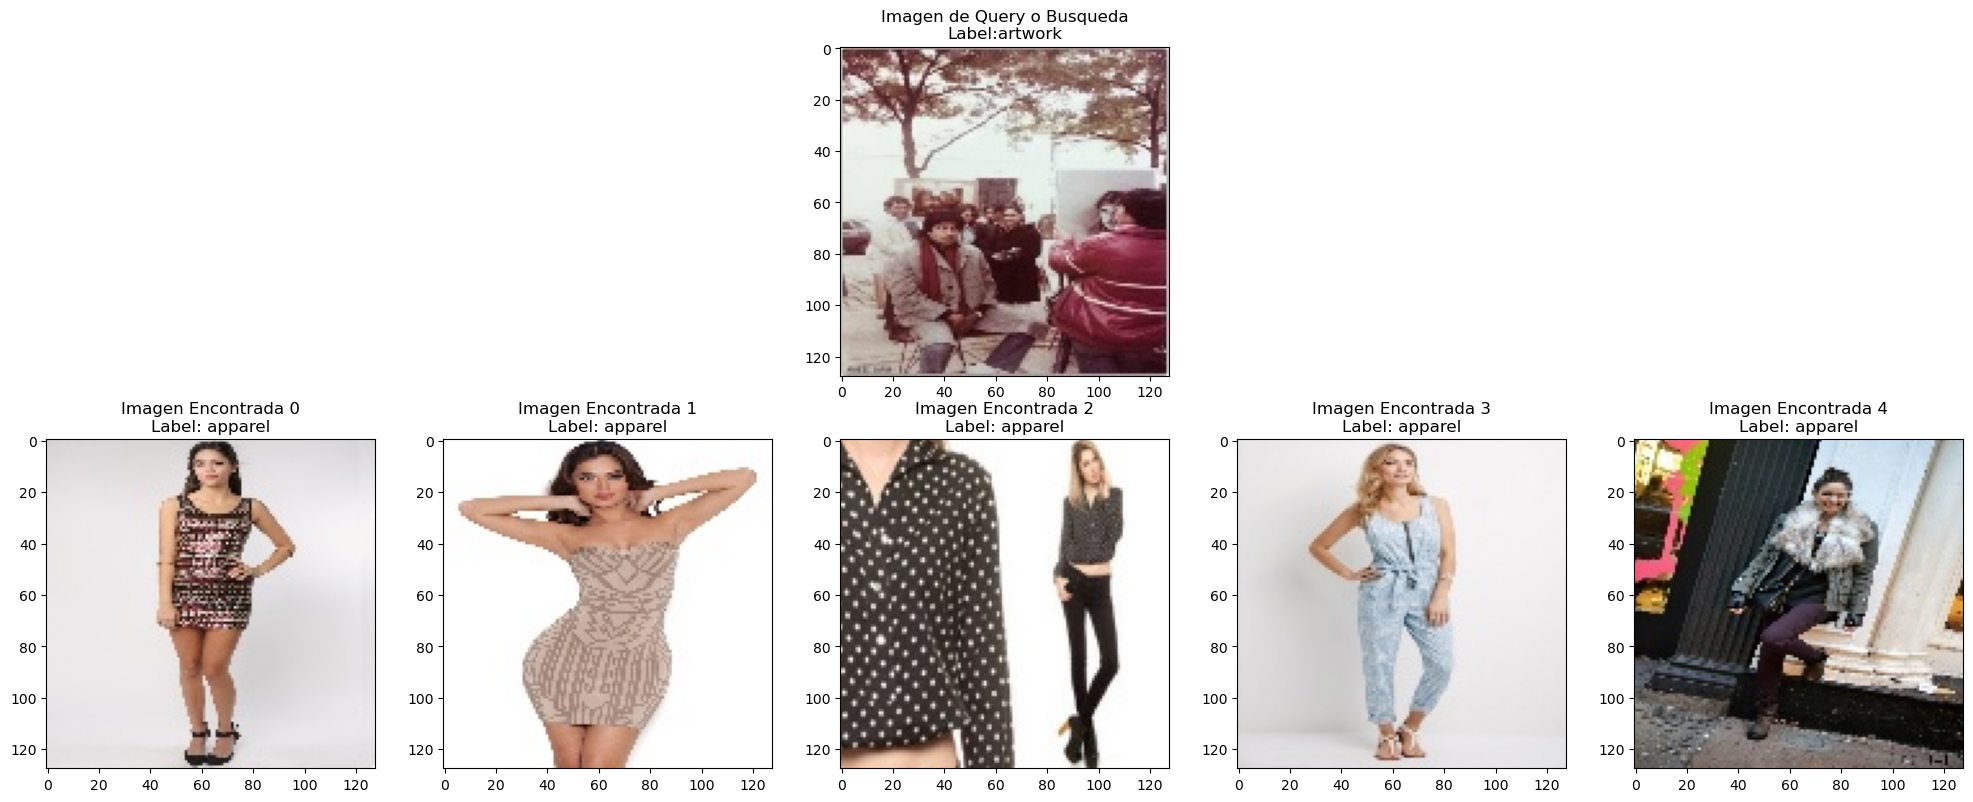

In [11]:
test_decs, test_desc_meta = extract_features(partial(cch_descriptor, bins = b), test_images, progress=False)

xr = match_all_images(test_decs, test_meta, descriptors, desc_meta, best_k=35, distance_function=cv2.NORM_L1)
fig, ax = plt.subplots(2, 5,  figsize = (20, 8))

test_img = 10
ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(xr[test_img][:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [12]:
calculate_metrics(xr, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

,Precision@K,Recall@K,R-Precision@K
K,,,
1,0.090909,0.001818,0.090909
5,0.090909,0.009091,0.090909
10,0.090909,0.018182,0.090909
25,0.090909,0.045455,0.090909


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


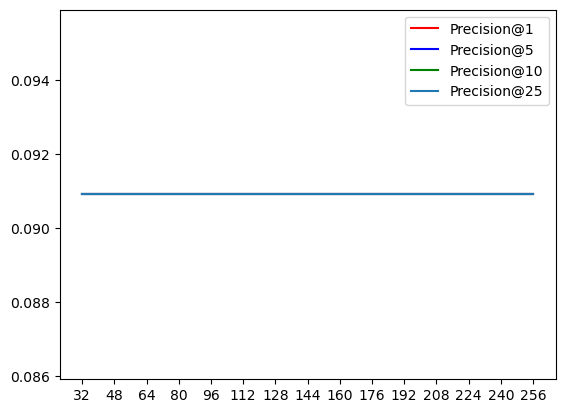

In [13]:
from tqdm import tqdm
scores1 = []
scores5 = []
scores10 = []
scores25 = []
scores50 = []
params = list(range(32, 257, 16))
for b in tqdm(params):
    cch_descriptor_func = partial(cch_descriptor, bins = b) 

    train_desc, train_index = extract_features(cch_descriptor_func, images)
    test_desc , test_index  = extract_features(cch_descriptor_func, test_images)

    results = match_all_images(test_desc, test_index, train_desc, train_index, best_k=50, distance_function=cv2.NORM_L2)
    rprecision = calculate_metrics(results, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

    scores1.append( rprecision.loc[ 1, 'Precision@K'])
    scores5.append( rprecision.loc[ 5, 'Precision@K'])
    scores10.append(rprecision.loc[10, 'Precision@K'])
    scores25.append(rprecision.loc[25, 'Precision@K'])

plt.plot(params, scores1 , 'r', label = "Precision@1")
plt.plot(params, scores5 , 'b', label = "Precision@5")
plt.plot(params, scores10, 'g', label = "Precision@10")
plt.plot(params, scores25,      label = "Precision@25")
plt.xticks(params)
plt.legend(bbox_to_anchor = (1, 1))
plt.show()